In [1]:
using Pkg
pkg"activate ."
pkg"add Plots"
pkg"add NLPModels"
pkg"add NLPModelsIpopt"
pkg"add SolverTools"
pkg"add SolverBenchmark"

 Activating environment at `~/Documents/streaming/notebooks/tutorials/creating-a-solver/Project.toml`
   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


    Fetching: [

    Fetching: [===============>                         ]  

    Fetching: [

    Fetching: [==============================>          ]  

    Fetching: [

Fetching: [========================================>]  100.0 %

  Resolving package versions...
   Updating `~/Documents/streaming/notebooks/tutorials/creating-a-solver/Project.toml`
 [no changes]
   Updating `~/Documents/streaming/notebooks/tutorials/creating-a-solver/Manifest.toml`
  [91d4177d] ↑ Opus_jll v1.3.1+0 ⇒ v1.3.1+1
  [f27f6e37] ↑ libvorbis_jll v1.3.6+2 ⇒ v1.3.6+3
  Resolving package versions...
   Updating `~/Documents/streaming/notebooks/tutorials/creating-a-solver/Project.toml`
 [no changes]
   Updating `~/Documents/streaming/notebooks/tutorials/creating-a-solver/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Documents/streaming/notebooks/tutorials/creating-a-solver/Project.toml`
 [no changes]
   Updating `~/Documents/streaming/notebooks/tutorials/creating-a-solver/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Documents/streaming/notebooks/tutorials/creating-a-solver/Project.toml`
 [no changes]
   Updating `~/Documents/streaming/notebooks/tutorials/creating-a-solver/Manifest.t

In [2]:
pkg"status"

Status `~/Documents/streaming/notebooks/tutorials/creating-a-solver/Project.toml`
  [1b53aba6] CUTEst v0.10.0
  [a4795742] NLPModels v0.12.2
  [f4238b75] NLPModelsIpopt v0.3.2
  [91a5bcdd] Plots v0.29.9
  [581a75fa] SolverBenchmark v0.1.0
  [b5612192] SolverTools v0.1.11


$$ \min\ f(x) \qquad \text{s.to} \qquad c(x) = 0. $$

\begin{align}
\nabla f(x) + J(x)^T y & = 0 \\
c(x) & = 0
\end{align}

\begin{align}
\begin{bmatrix}
\nabla^2 f(x_k) + \sum_{i=1}^m (y_k)_i \nabla^2 c_i(x_k) & J(x_k)^T \\
J(x_k) & 0
\end{bmatrix}
\begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix}
=
- \begin{bmatrix} \nabla f(x_k) + J(x_k)^T y_k \\ c(x_k) \end{bmatrix}
\end{align}

In [3]:
using NLPModels

nlp = ADNLPModel(x -> (x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2, [-1.2; 1.0],
    c=x -> [x[1]^2 + x[2]^2 - 1.0], lcon=[0.0], ucon=[0.0]
)

ADNLPModel(Minimization problem Generic
nvar = 2, ncon = 1 (0 linear)
, Counters(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), var"#3#5"(), var"#4#6"())

In [4]:
nlp.meta

Minimization problem Generic
nvar = 2, ncon = 1 (0 linear)


In [5]:
nlp.meta.x0, nlp.meta.nvar, nlp.meta.lvar, nlp.meta.uvar

([-1.2, 1.0], 2, [-Inf, -Inf], [Inf, Inf])

In [6]:
nlp.meta.y0, nlp.meta.ncon, nlp.meta.lcon, nlp.meta.ucon

([0.0], 1, [0.0], [0.0])

In [7]:
nlp.meta.jfix # Vector of constraints that are equalities

1-element Array{Int64,1}:
 1

In [8]:
equality_constrained(nlp)

true

In [9]:
unconstrained(nlp)

false

In [10]:
x = copy(nlp.meta.x0)
obj(nlp, x)

24.199999999999996

In [11]:
grad(nlp, x)

2-element Array{Float64,1}:
 -215.59999999999997
  -87.99999999999999

In [12]:
hess(nlp, x)

2×2 Array{Float64,2}:
 1330.0    0.0
  480.0  200.0

In [13]:
cons(nlp, x)

1-element Array{Float64,1}:
 1.44

In [14]:
jac(nlp, x)

1×2 Array{Float64,2}:
 -2.4  2.0

In [15]:
y = ones(nlp.meta.ncon)
hess(nlp, x, y) # Hessian of the Lagrangian

2×2 Array{Float64,2}:
 1332.0    0.0
  480.0  202.0

In [16]:
neval_obj(nlp)

1

In [17]:
sum_counters(nlp)

6

In [18]:
nlp.counters

Counters(1, 1, 1, 0, 0, 1, 0, 0, 2, 0, 0)

In [19]:
using LinearAlgebra, SolverTools

# Input of an NLPModels compliant solver is:
function sqp(nlp :: AbstractNLPModel; # Only mandatory argument
             max_eval = 100,
             max_time = 3.0,
             atol = 1e-6,
             rtol = 1e-6,
             )
    
    start_time = time()
    
    nvar, ncon = nlp.meta.nvar, nlp.meta.ncon
    
    x = copy(nlp.meta.x0)
    y = ones(ncon)
    
    f(x) = obj(nlp, x)
    ∇f(x) = grad(nlp, x)
    H(x,y) = hess(nlp, x, y)
    c(x) = cons(nlp, x)
    J(x) = jac(nlp, x)
    
    Jx = J(x)
    dual = ∇f(x) + Jx' * y
    primal = c(x)
    
    ϵd = atol + rtol * norm(dual)
    ϵp = atol
    
    Δt = time() - start_time
    solved = norm(dual) < ϵd && norm(primal) < ϵp
    tired  = Δt > max_time || sum_counters(nlp) > max_eval
    iter = 0
    
    @info log_header([:iter, :fx, :dual, :primal],
                     [Int, Float64, Float64, Float64],
                     hdr_override=Dict(:fx => "f(x)",
                                       :dual => "‖∇ℓ(x,y)‖",
                                       :primal => "‖c(x)‖"))
    
    @info log_row(Any[iter, f(x), norm(dual), norm(primal)])
    
    while !(solved || tired)
        Hxy = H(x, y)
        W = [Hxy zeros(nvar, ncon); Jx zeros(ncon, ncon)]
        Δxy = -Symmetric(W, :L) \ [dual; primal]
        Δx = Δxy[1:nvar]
        Δy = Δxy[nvar+1:end]
        
        x += Δx
        y += Δy
        
        Jx = J(x)
        dual = ∇f(x) + Jx' * y
        primal = c(x)
        Δt = time() - start_time
        solved = norm(dual) < ϵd && norm(primal) < ϵp
        tired  = Δt > max_time || sum_counters(nlp) > max_eval
        iter += 1
        
        @info log_row(Any[iter, f(x), norm(dual), norm(primal)])
    end
    
    status = if solved
        :first_order
    elseif tired
        if Δt > max_time
            :max_time
        else
            :max_eval
        end
    else
        :unknown
    end
    
    return GenericExecutionStats(status, nlp;
                solution=x, objective=f(x), dual_feas=norm(dual),
                primal_feas=norm(primal), elapsed_time=Δt, iter=iter,
                solver_specific=Dict(:multiplers => y)) # should change to multipliers
end

┌ Info: Precompiling SolverTools [b5612192-2639-5dc1-abfe-fbedd65fab29]
└ @ Base loading.jl:1260


sqp (generic function with 1 method)

In [20]:
# Rosenbrock with x₁² + x₂² = 1
reset!(nlp)
output = sqp(nlp)

┌ Info:   iter      f(x)  ‖∇ℓ(x,y)‖    ‖c(x)‖  
└ @ Main In[19]:36
┌ Info:      0   2.4e+01   2.3e+02   1.4e+00
└ @ Main In[19]:42
┌ Info:      1   6.2e+00   7.8e+01   2.2e-01
└ @ Main In[19]:62
┌ Info:      2   3.2e+00   1.1e+01   1.1e-02
└ @ Main In[19]:62
┌ Info:      3   3.2e+00   1.9e-01   1.4e-04
└ @ Main In[19]:62
┌ Info:      4   3.2e+00   5.9e-05   5.3e-08
└ @ Main In[19]:62


"Execution stats: first-order stationary"

In [21]:
print(output)

Generic Execution stats
  status: "first-order stationary"
  objective value: 3.186379049574157
  primal feasibility: 5.3240614139582476e-8
  dual feasibility: 5.894431731404969e-5
  solution: [-0.7839302491531344  0.6208489491843557]
  iterations: 4
  elapsed time: 1.995298147201538
  solver specific:
    multiplers: [-1.0151246847136168]


In [22]:
sum_counters(nlp)

25

In [23]:
SolverTools.show_statuses()

STATUSES:
  :acceptable     => solved to within acceptable tolerances
  :exception      => unhandled exception
  :first_order    => first-order stationary
  :infeasible     => problem may be infeasible
  :max_eval       => maximum number of function evaluations
  :max_iter       => maximum iteration
  :max_time       => maximum elapsed time
  :neg_pred       => negative predicted reduction
  :not_desc       => not a descent direction
  :small_residual => small residual
  :small_step     => step too small
  :stalled        => stalled
  :unbounded      => objective function may be unbounded from below
  :unknown        => unknown
  :user           => user-requested stop


In [24]:
problems = (
    ADNLPModel(x -> i * x[1]^2 + (i + 2) * (x[2] - i * x[1]^2)^2, ones(2),
        c=x->[i * x[1] - (i + 3) * x[2]], lcon=[0.0], ucon=[0.0], name="prob$i") for i = 1:5
)

Base.Generator{UnitRange{Int64},var"#13#16"}(var"#13#16"(), 1:5)

In [25]:
for nlp in problems
    output = sqp(nlp)
    print(output)
end

Generic Execution stats
  status: "first-order stationary"
  objective value: 4.655789559984491e-16
  primal feasibility: 2.710505431213761e-20
  dual feasibility: 7.00763642646916e-8
  solution: [-1.9800668661838186e-8  -4.95016716545277e-9]
  iterations: 6
  elapsed time: 0.4042689800262451
  solver specific:
    multiplers: [8.241736648585804e-9]
Generic Execution stats
  status: "first-order stationary"
  objective value: 1.3898760039745041e-12
  primal feasibility: 8.131516293641283e-20
  dual feasibility: 4.083447386054358e-6
  solution: [-7.255806345781552e-7  -2.9023225383127834e-7]
  iterations: 7
  elapsed time: 0.0006649494171142578
  solver specific:
    multiplers: [1.7224173981590673e-7]
Generic Execution stats
  status: "first-order stationary"
  objective value: 7.279432718550528e-17
  primal feasibility: 0.0
  dual feasibility: 3.3164442169477714e-8
  solution: [-4.138608067289954e-9  -2.069304033644977e-9]
  iterations: 9
  elapsed time: 0.0005021095275878906
  solver

┌ Info:   iter      f(x)  ‖∇ℓ(x,y)‖    ‖c(x)‖  
└ @ Main In[19]:36
┌ Info:      0   1.0e+00   5.0e+00   3.0e+00
└ @ Main In[19]:42
┌ Info:      1   3.2e-01   2.5e+00   2.2e-16
└ @ Main In[19]:62
┌ Info:      2   8.2e-02   7.4e-01   5.6e-17
└ @ Main In[19]:62
┌ Info:      3   5.5e-03   3.5e-01   0.0e+00
└ @ Main In[19]:62
┌ Info:      4   6.4e-05   3.8e-02   5.6e-17
└ @ Main In[19]:62
┌ Info:      5   1.2e-08   3.5e-04   1.7e-18
└ @ Main In[19]:62
┌ Info:      6   4.7e-16   7.0e-08   2.7e-20
└ @ Main In[19]:62
┌ Info:   iter      f(x)  ‖∇ℓ(x,y)‖    ‖c(x)‖  
└ @ Main In[19]:36
┌ Info:      0   6.0e+00   4.0e+01   3.0e+00
└ @ Main In[19]:42
┌ Info:      1   2.1e+00   1.3e+01   4.4e-16
└ @ Main In[19]:62
┌ Info:      2   5.4e-01   4.2e+00   0.0e+00
└ @ Main In[19]:62
┌ Info:      3   1.6e-01   1.6e+00   0.0e+00
└ @ Main In[19]:62
┌ Info:      4   3.6e-02   7.2e-01   0.0e+00
└ @ Main In[19]:62
┌ Info:      5   3.4e-04   3.4e-01   0.0e+00
└ @ Main In[19]:62
┌ Info:      6   5.3e-07   2.5e-03

In [26]:
stats = solve_problems(sqp, problems)

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:66
┌ Info:           prob1       2       1      first_order   3.0e-04   4.7e-16   7.0e-08   2.7e-20
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:           prob2       2       1      first_order   2.8e-04   1.4e-12   4.1e-06   8.1e-20
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:           prob3       2       1      first_order   1.8e-04   7.3e-17   3.3e-08   0.0e+00
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:           prob4       2       1      first_order   2.4e-04   6.6e-12   1.1e-05   1.9e-19
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:           prob5       2       1      first_order   1.8e-04   1.9e

,id,name,nvar,ncon,nequ,status,objective,elapsed_time,iter
,Int64,String,Int64,Int64,Int64,Symbol,Float64,Float64,Int64
1,1,prob1,2,1,0,first_order,4.65579e-16,0.000303984,6
2,2,prob2,2,1,0,first_order,1.38988e-12,0.00027895,7
3,3,prob3,2,1,0,first_order,7.27943e-17,0.000182152,9
4,4,prob4,2,1,0,first_order,6.5658e-12,0.000235081,9
5,5,prob5,2,1,0,first_order,1.9076e-14,0.000184059,10


In [27]:
using SolverBenchmark

┌ Info: Precompiling SolverBenchmark [581a75fa-a23a-52d0-a590-d6201de2218a]
└ @ Base loading.jl:1260


In [28]:
markdown_table(stdout, stats, cols=[:name, :status, :objective, :elapsed_time])

┌ Warning: `haskey(df::AbstractDataFrame, key::Symbol)` is deprecated, use `hasproperty(df, key)` instead.
│   caller = #3 at none:0 [inlined]
└ @ Core ./none:0
┌ Warning: `haskey(df::AbstractDataFrame, key::Symbol)` is deprecated, use `hasproperty(df, key)` instead.
│   caller = #3 at none:0 [inlined]
└ @ Core ./none:0
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = (::SolverBenchmark.var"#4#8"{Dict{Symbol,Function},DataFrames.DataFrame,typeof(MDformat)})(::Symbol) at array.jl:0
└ @ SolverBenchmark ./array.jl:0
┌ Warning: pretty_table(io, data, header, tf; kwargs...) is deprecated. Please, use pretty_table(io, data, header; tf = tf, kwargs...)
└ @ PrettyTables /home/abel/.julia/packages/PrettyTables/BRTPU/src/deprecations.jl:29


|  name |      status | objective | elapsed_time |
|-------|-------------|-----------|--------------|
| prob1 | first_order |   4.7e-16 |      3.0e-04 |
| prob2 | first_order |   1.4e-12 |      2.8e-04 |
| prob3 | first_order |   7.3e-17 |      1.8e-04 |
| prob4 | first_order |   6.6e-12 |      2.4e-04 |
| prob5 | first_order |   1.9e-14 |      1.8e-04 |


|  name |      status | objective | elapsed_time |
|-------|-------------|-----------|--------------|
| prob1 | first_order |   4.7e-16 |      1.7e-04 |
| prob2 | first_order |   1.4e-12 |      1.4e-04 |
| prob3 | first_order |   7.3e-17 |      1.5e-04 |
| prob4 | first_order |   6.6e-12 |      1.5e-04 |
| prob5 | first_order |   1.9e-14 |      1.6e-04 |


In [29]:
latex_table(stdout, stats, cols=[:name, :status, :objective, :elapsed_time])

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = (::SolverBenchmark.var"#4#8"{Dict{Symbol,Function},DataFrames.DataFrame,typeof(LTXformat)})(::Symbol) at array.jl:0
└ @ SolverBenchmark ./array.jl:0


\begin{longtable}[c]{lrrr}
\hline 
name & status & objective & elapsed\_time \\
\hline 
\endfirsthead
\multicolumn{4}{l}
{{\bfseries \tablename\ \thetable{} --- continued from previous page}} \\
\hline 
name & status & objective & elapsed\_time \\
\hline 
\endhead
\hline 
\multicolumn{4}{r}{{\bfseries Continued on next page}} \\
\hline 
\endfoot
\hline 
\endlastfoot
prob1 & first\_order & \( 4.7\)e\(-16\) & \( 3.0\)e\(-04\) \\
prob2 & first\_order & \( 1.4\)e\(-12\) & \( 2.8\)e\(-04\) \\
prob3 & first\_order & \( 7.3\)e\(-17\) & \( 1.8\)e\(-04\) \\
prob4 & first\_order & \( 6.6\)e\(-12\) & \( 2.4\)e\(-04\) \\
prob5 & first\_order & \( 1.9\)e\(-14\) & \( 1.8\)e\(-04\) \\
\hline 
\end{longtable}


In [30]:
using NLPModelsIpopt

┌ Info: Precompiling NLPModelsIpopt [f4238b75-b362-5c4c-b852-0801c9a21d71]
└ @ Base loading.jl:1260


In [31]:
output = ipopt(nlp)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equ

"Execution stats: first-order stationary"

In [32]:
print(output)

Generic Execution stats
  status: "first-order stationary"
  objective value: 0.045674808719500054
  primal feasibility: 1.3322676295501878e-15
  dual feasibility: 1.4624135236118718e-12
  solution: [0.7864151541684294  0.6176983125233926]
  iterations: 21
  elapsed time: 1.652
  solver specific:
    multipliers_U: [0.0  0.0]
    multipliers_L: [0.0  0.0]
    multipliers_con: [0.1214965569995277]
    internal_msg: :Solve_Succeeded


In [33]:
solve_problems(ipopt, problems)

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:66
┌ Info:           prob1       2       1      first_order   1.0e-03   0.0e+00   0.0e+00   0.0e+00
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82


This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

┌ Info:           prob2       2       1      first_order   0.0e+00   0.0e+00   0.0e+00   0.0e+00
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:           prob3       2       1      first_order   0.0e+00   0.0e+00   0.0e+00   0.0e+00
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:           prob4       2       1      first_order   1.0e-03   0.0e+00   0.0e+00   0.0e+00
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:           prob5       2       1      first_order   0.0e+00   0.0e+00   0.0e+00   0.0e+00
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82


,id,name,nvar,ncon,nequ,status,objective,elapsed_time,iter
,Int64,String,Int64,Int64,Int64,Symbol,Float64,Float64,Int64
1,1,prob1,2,1,0,first_order,0.0,0.001,0
2,2,prob2,2,1,0,first_order,0.0,0.0,0
3,3,prob3,2,1,0,first_order,0.0,0.0,0
4,4,prob4,2,1,0,first_order,0.0,0.001,0
5,5,prob5,2,1,0,first_order,0.0,0.0,0


In [34]:
solvers = Dict(
    :SQP => sqp,
    :IPOPT => (nlp; kwargs...) -> ipopt(nlp, print_level=0; kwargs...)
)

Dict{Symbol,Function} with 2 entries:
  :IPOPT => #19
  :SQP   => sqp

In [35]:
df = bmark_solvers(solvers, problems)

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:66
┌ Info:           prob1       2       1      first_order   0.0e+00   0.0e+00   0.0e+00   0.0e+00
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:           prob2       2       1      first_order   0.0e+00   0.0e+00   0.0e+00   0.0e+00
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:           prob3       2       1      first_order   0.0e+00   0.0e+00   0.0e+00   0.0e+00
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:           prob4       2       1      first_order   0.0e+00   0.0e+00   0.0e+00   0.0e+00
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:           prob5       2       1      first_order   0.0e+00   0.0e

Dict{Symbol,DataFrames.DataFrame} with 2 entries:
  :IPOPT => 5×34 DataFrames.DataFrame. Omitted printing of 27 columns…
  :SQP   => 5×31 DataFrames.DataFrame. Omitted printing of 24 columns…

In [36]:
df[:SQP]

,id,name,nvar,ncon,nequ,status,objective,elapsed_time,iter
,Int64,String,Int64,Int64,Int64,Symbol,Float64,Float64,Int64
1,1,prob1,2,1,0,first_order,4.65579e-16,0.031507,6
2,2,prob2,2,1,0,first_order,1.38988e-12,0.00019002,7
3,3,prob3,2,1,0,first_order,7.27943e-17,0.000150204,9
4,4,prob4,2,1,0,first_order,6.5658e-12,0.00014782,9
5,5,prob5,2,1,0,first_order,1.9076e-14,0.000199795,10


In [37]:
df[:IPOPT]

,id,name,nvar,ncon,nequ,status,objective,elapsed_time,iter
,Int64,String,Int64,Int64,Int64,Symbol,Float64,Float64,Int64
1,1,prob1,2,1,0,first_order,0.0,0.0,0
2,2,prob2,2,1,0,first_order,0.0,0.0,0
3,3,prob3,2,1,0,first_order,0.0,0.0,0
4,4,prob4,2,1,0,first_order,0.0,0.0,0
5,5,prob5,2,1,0,first_order,0.0,0.0,0


In [38]:
df_join = SolverBenchmark.join(df, [:objective, :elapsed_time],
    invariant_cols=[:name, :nvar, :ncon]
)

┌ Warning: `getindex(df::DataFrame, col_inds::Union{AbstractVector, Regex, Not})` is deprecated, use `df[:, col_inds]` instead.
│   caller = join(::Dict{Symbol,DataFrames.DataFrame}, ::Array{Symbol,1}; invariant_cols::Array{Symbol,1}, hdr_override::Dict{Symbol,String}) at join.jl:49
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/VWv02/src/join.jl:49
┌ Warning: `getindex(df::DataFrame, col_inds::Union{AbstractVector, Regex, Not})` is deprecated, use `df[:, col_inds]` instead.
│   caller = join(::Dict{Symbol,DataFrames.DataFrame}, ::Array{Symbol,1}; invariant_cols::Array{Symbol,1}, hdr_override::Dict{Symbol,String}) at join.jl:58
└ @ SolverBenchmark /home/abel/.julia/packages/SolverBenchmark/VWv02/src/join.jl:58


,id,name,nvar,ncon,objective_IPOPT,elapsed_time_IPOPT,objective_SQP
,Int64,String,Int64,Int64,Float64,Float64,Float64
1,1,prob1,2,1,0.0,0.0,4.65579e-16
2,2,prob2,2,1,0.0,0.0,1.38988e-12
3,3,prob3,2,1,0.0,0.0,7.27943e-17
4,4,prob4,2,1,0.0,0.0,6.5658e-12
5,5,prob5,2,1,0.0,0.0,1.9076e-14


**Comparing our solver and IPOPT on CUTEst problems**

In [39]:
using Pkg
pkg"add CUTEst"

  Resolving package versions...
   Updating `~/Documents/streaming/notebooks/tutorials/creating-a-solver/Project.toml`
 [no changes]
   Updating `~/Documents/streaming/notebooks/tutorials/creating-a-solver/Manifest.toml`
 [no changes]


In [40]:
using CUTEst

┌ Info: Precompiling CUTEst [1b53aba6-35b6-5f92-a507-53c67d53f819]
└ @ Base loading.jl:1260
┌ Info: using problem repository
│   ENV["MASTSIF"] = /home/abel/.julia/packages/CUTEst/Qj8fj/src/../deps/sif
└ @ CUTEst /home/abel/.julia/packages/CUTEst/Qj8fj/src/CUTEst.jl:78


In [41]:
# CUTEst.fetch_sif_problems() # Run in your terminal due to badcert

In [42]:
nlp = CUTEstModel("HS7")

Minimization problem HS7
nvar = 2, ncon = 1 (0 linear)


In [43]:
CUTEstModel <: AbstractNLPModel

true

In [44]:
equality_constrained(nlp)

true

In [45]:
!has_bounds(nlp)

true

In [46]:
sqp(nlp)

┌ Info:   iter      f(x)  ‖∇ℓ(x,y)‖    ‖c(x)‖  
└ @ Main In[19]:36
┌ Info:      0  -3.9e-01   4.1e+01   2.5e+01
└ @ Main In[19]:42
┌ Info:      1  -1.9e-03   1.3e+01   7.1e+00
└ @ Main In[19]:62
┌ Info:      2  -4.8e-01   4.4e+00   2.0e+00
└ @ Main In[19]:62
┌ Info:      3  -1.6e+00   1.6e+00   1.7e+00
└ @ Main In[19]:62
┌ Info:      4  -2.2e+00   3.3e-01   1.9e+00
└ @ Main In[19]:62
┌ Info:      5  -1.8e+00   3.9e-02   2.0e-01
└ @ Main In[19]:62
┌ Info:      6  -1.7e+00   2.0e-03   3.2e-03
└ @ Main In[19]:62
┌ Info:      7  -1.7e+00   1.4e-06   9.2e-07
└ @ Main In[19]:62


"Execution stats: first-order stationary"

In [47]:
pnames = CUTEst.select(max_var=2, min_con=1, max_con=2,
                       only_free_var=true, only_equ_con=true)

28-element Array{String,1}:
 "WAYSEA1NE"
 "HS7"
 "GOTTFR"
 "MARATOS"
 "HS6"
 "CUBENE"
 "HS8"
 "BT1"
 "PRICE4NE"
 "POWELLSQ"
 "BT10"
 "HS9"
 "POWELLBS"
 ⋮
 "BOOTH"
 "DENSCHNFNE"
 "HIMMELBC"
 "HYPCIR"
 "S316-322"
 "HIMMELBD"
 "FLT"
 "FREURONE"
 "RSNBRNE"
 "CLUSTER"
 "HIMMELBA"
 "SINVALNE"

In [48]:
# Can't open more than one problem at the same time
CUTEstModel("HS8")

ErrorException: CUTEst: call finalize on current model first

In [49]:
finalize(nlp)

In [50]:
# You need to pass a list of problems to bmark_solver or solve_problems
problems = (CUTEstModel(p) for p in pnames)

Base.Generator{Array{String,1},Type{CUTEstModel}}(CUTEstModel, ["WAYSEA1NE", "HS7", "GOTTFR", "MARATOS", "HS6", "CUBENE", "HS8", "BT1", "PRICE4NE", "POWELLSQ"  …  "HIMMELBC", "HYPCIR", "S316-322", "HIMMELBD", "FLT", "FREURONE", "RSNBRNE", "CLUSTER", "HIMMELBA", "SINVALNE"])

In [51]:
# Generator vs vector compreheension
[i for i = 1:3]

3-element Array{Int64,1}:
 1
 2
 3

In [52]:
(i for i = 1:3)

Base.Generator{UnitRange{Int64},typeof(identity)}(identity, 1:3)

In [53]:
df = solve_problems(sqp, problems)

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:66
┌ Info:       WAYSEA1NE       2       2      first_order   2.9e-02   0.0e+00   2.4e-07   2.7e-08
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:             HS7       2       1      first_order   4.2e-04  -1.7e+00   1.4e-06   9.2e-07
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:          GOTTFR       2       2      first_order   1.6e-02   0.0e+00   1.6e-06   1.1e-09
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:         MARATOS       2       1      first_order   2.9e-04  -1.0e+00   4.8e-11   4.7e-11
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:             HS6       2       1      first_order   3.2e-04   0.0e

,id,name,nvar,ncon,nequ,status,objective,elapsed_time,iter
,Int64,String,Int64,Int64,Int64,Symbol,Float64,Float64,Int64
1,1,WAYSEA1NE,2,2,0,first_order,0.0,0.0291741,7
2,2,HS7,2,1,0,first_order,-1.73205,0.000424147,7
3,3,GOTTFR,2,2,0,first_order,0.0,0.016371,7
4,4,MARATOS,2,1,0,first_order,-1.0,0.000287056,4
5,5,HS6,2,1,0,first_order,0.0,0.000315905,3
6,6,CUBENE,2,2,0,first_order,0.0,0.000247002,2
7,7,HS8,2,2,0,first_order,-1.0,0.000550985,5
8,8,BT1,2,1,0,first_order,-1.0,0.00068903,11
9,9,PRICE4NE,2,2,0,first_order,0.0,0.00125504,19


In [54]:
Dict(k => count(df.status .== k) for k in unique(df.status))

Dict{Symbol,Int64} with 3 entries:
  :first_order => 21
  :max_eval    => 3
  :exception   => 4

In [55]:
df[df.status .== :exception,:]

,id,name,nvar,ncon,nequ,status,objective,elapsed_time,iter
,Int64,String,Int64,Int64,Int64,Symbol,Float64,Float64,Int64
1,12,HS9,2,1,0,exception,Inf,Inf,0
2,21,S316-322,2,1,0,exception,Inf,Inf,0
3,23,FLT,2,2,0,exception,Inf,Inf,0
4,26,CLUSTER,2,2,0,exception,Inf,Inf,0


In [56]:
solvers

Dict{Symbol,Function} with 2 entries:
  :IPOPT => #19
  :SQP   => sqp

In [57]:
stats = bmark_solvers(solvers, problems)

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:66
┌ Info:       WAYSEA1NE       2       2      first_order   4.8e-02   0.0e+00   0.0e+00   0.0e+00
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:             HS7       2       1      first_order   3.0e-03  -1.7e+00   2.2e-16   4.4e-16
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:          GOTTFR       2       2      first_order   0.0e+00   0.0e+00   0.0e+00   0.0e+00
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:         MARATOS       2       1      first_order   3.0e-03  -1.0e+00   2.7e-09   1.1e-14
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:             HS6       2       1      first_order   0.0e+00   0.0e

┌ Info:      DENSCHNCNE       2       2      first_order   5.6e-04   0.0e+00   3.4e-09   2.4e-11
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:       WAYSEA2NE       2       2      first_order   7.1e-04   0.0e+00   2.5e-08   9.3e-10
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:           BOOTH       2       2      first_order   1.8e-04   0.0e+00   5.0e-16   8.9e-16
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:      DENSCHNFNE       2       2      first_order   6.1e-04   0.0e+00   2.8e-12   1.7e-13
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:        HIMMELBC       2       2      first_order   4.5e-04   0.0e+00   1.7e-06   6.5e-08
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:          HYPCIR       2       2      first_order   4.1e-04   0.0e+0

Dict{Symbol,DataFrames.DataFrame} with 2 entries:
  :IPOPT => 28×34 DataFrames.DataFrame. Omitted printing of 27 columns…
  :SQP   => 28×31 DataFrames.DataFrame. Omitted printing of 24 columns…

┌ Warning: some measures are zero; shifting all by one
└ @ BenchmarkProfiles /home/abel/.julia/packages/BenchmarkProfiles/GSiYy/src/performance_profiles.jl:15


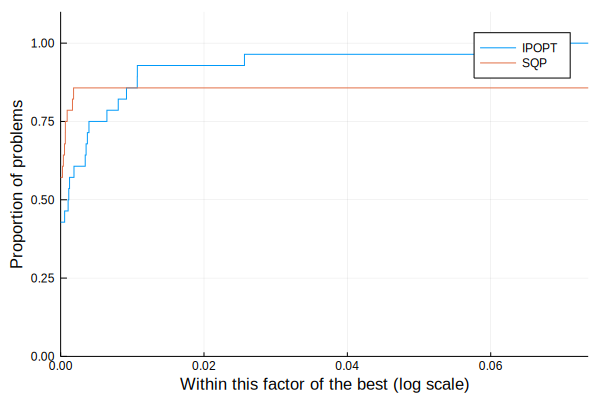

In [58]:
using SolverBenchmark

cost(df) = df.elapsed_time
performance_profile(stats, cost)

In [59]:
# Copied from above

using LinearAlgebra, NLPModels, SolverTools

# Input of an NLPModels compliant solver is:
function sqp(nlp :: AbstractNLPModel; # Only mandatory argument
             max_eval = 100,
             max_time = 3.0,
             atol = 1e-6,
             rtol = 1e-6,
             )
    
    start_time = time()
    
    nvar, ncon = nlp.meta.nvar, nlp.meta.ncon
    
    x = copy(nlp.meta.x0)
    y = ones(ncon)
    
    f(x) = obj(nlp, x)
    ∇f(x) = grad(nlp, x)
    H(x,y) = hess(nlp, x, y)
    c(x) = cons(nlp, x)
    J(x) = jac(nlp, x)
    
    Jx = J(x)
    dual = ∇f(x) + Jx' * y
    primal = c(x)
    
    ϵd = atol + rtol * norm(dual)
    ϵp = atol
    
    Δt = time() - start_time
    solved = norm(dual) < ϵd && norm(primal) < ϵp
    tired  = Δt > max_time || sum_counters(nlp) > max_eval
    iter = 0
    
    @info log_header([:iter, :fx, :dual, :primal],
                     [Int, Float64, Float64, Float64],
                     hdr_override=Dict(:fx => "f(x)",
                                       :dual => "‖∇ℓ(x,y)‖",
                                       :primal => "‖c(x)‖"))
    
    @info log_row(Any[iter, f(x), norm(dual), norm(primal)])
    
    while !(solved || tired)
        Hxy = H(x, y)
        W = [Hxy zeros(nvar, ncon); Jx zeros(ncon, ncon)]
        Δxy = -Symmetric(W, :L) \ [dual; primal]
        Δx = Δxy[1:nvar]
        Δy = Δxy[nvar+1:end]
        
        x += Δx
        y += Δy
        
        Jx = J(x)
        dual = ∇f(x) + Jx' * y
        primal = c(x)
        Δt = time() - start_time
        solved = norm(dual) < ϵd && norm(primal) < ϵp
        tired  = Δt > max_time || sum_counters(nlp) > max_eval
        iter += 1
        
        @info log_row(Any[iter, f(x), norm(dual), norm(primal)])
    end
    
    status = if solved
        :first_order
    elseif tired
        if Δt > max_time
            :max_time
        else
            :max_eval
        end
    else
        :unknown
    end
    
    return GenericExecutionStats(status, nlp;
                solution=x, objective=f(x), dual_feas=norm(dual),
                primal_feas=norm(primal), elapsed_time=Δt, iter=iter,
                solver_specific=Dict(:multiplers => y)) # should change to multipliers
end

sqp (generic function with 1 method)

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:66
┌ Info:       WAYSEA1NE       2       2      first_order   1.0e-03   0.0e+00   0.0e+00   0.0e+00
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:             HS7       2       1      first_order   4.0e-03  -1.7e+00   2.2e-16   4.4e-16
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:          GOTTFR       2       2      first_order   0.0e+00   0.0e+00   0.0e+00   0.0e+00
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:         MARATOS       2       1      first_order   4.0e-03  -1.0e+00   2.7e-09   1.1e-14
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:             HS6       2       1      first_order   1.0e-03   0.0e

┌ Info:      DENSCHNCNE       2       2      first_order   5.0e-04   0.0e+00   3.4e-09   2.4e-11
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:       WAYSEA2NE       2       2      first_order   8.3e-04   0.0e+00   2.5e-08   9.3e-10
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:           BOOTH       2       2      first_order   1.8e-04   0.0e+00   5.0e-16   8.9e-16
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:      DENSCHNFNE       2       2      first_order   8.6e-04   0.0e+00   2.8e-12   1.7e-13
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:        HIMMELBC       2       2      first_order   7.8e-04   0.0e+00   1.7e-06   6.5e-08
└ @ SolverTools /home/abel/.julia/packages/SolverTools/Zu4eO/src/bmark/run_solver.jl:82
┌ Info:          HYPCIR       2       2      first_order   6.8e-04   0.0e+0

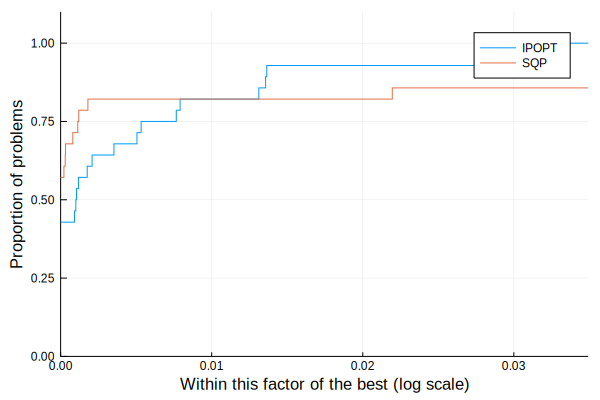

In [60]:
using CUTEst, NLPModelsIpopt, SolverBenchmark

pnames = CUTEst.select(max_var=2, min_con=1, max_con=2,
    only_free_var=true, only_equ_con=true)
problems = (CUTEstModel(p) for p in pnames)
solvers = Dict(:SQP => sqp,
    :IPOPT => (nlp; kwargs...) -> ipopt(nlp, print_level=0; kwargs...))

stats = bmark_solvers(solvers, problems)
cost(df) = df.elapsed_time
performance_profile(stats, cost)

In [61]:
stats[:SQP].sum_counters = sum(stats[:SQP][:,c]
    for c in fieldnames(Counters))
open("sqp-results.tex", "w") do io
    latex_table(io, stats[:SQP], cols=[:name, :status, :objective, :elapsed_time, :sum_counters])
end

In [62]:
?performance_profile

search: performance_profile



Produce a performance profile.

Each column of the matrix `T` defines the performance data for a solver (smaller is better). Failures on a given problem are represented by a negative value, an infinite value, or `NaN`. The optional argument `logscale` is used to produce a logarithmic (base 2) performance plot.

---

```
performance_profile(stats, cost)
```

Produce a performance profile comparing solvers in `stats` using the `cost` function.

Inputs:

  * `stats::Dict{Symbol,DataFrame}`: pairs of `:solver => df`;
  * `cost::Function`: cost function applyed to each `df`. Should return a vector with the cost of solving the problem at each row;

      * 0 cost is not allowed;
      * If the solver did not solve the problem, return Inf or a negative number.

Examples of cost functions:

  * `cost(df) = df.elapsed_time`: Simple `elapsed_time` cost. Assumes the solver solved the problem.
  * `cost(df) = (df.status .!= :first_order) * Inf + df.elapsed_time`: Takes into consideration the status of the solver.


┌ Warning: some measures are zero; shifting all by one
└ @ BenchmarkProfiles /home/abel/.julia/packages/BenchmarkProfiles/GSiYy/src/performance_profiles.jl:15


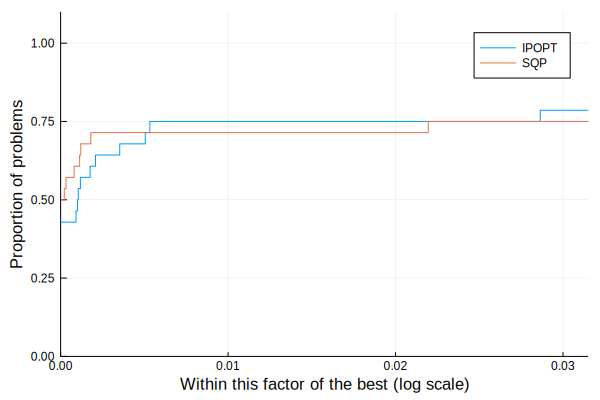

In [63]:
cost(df) = (df.status .!= :first_order) * Inf + df.elapsed_time
performance_profile(stats, cost)

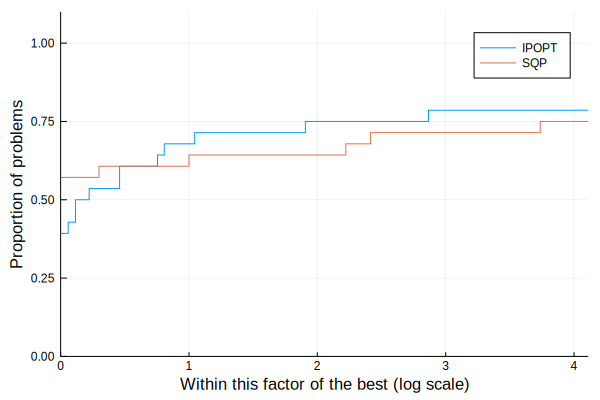

In [64]:
for s in [:SQP, :IPOPT]
    stats[s].sum_counters = sum(stats[s][:,c] for c in fieldnames(Counters))
end
cost(df) = (df.status .!= :first_order) * Inf + df.sum_counters
performance_profile(stats, cost)